In [1]:
import logging

In [2]:
logging.__path__

['/Users/sandro/.miniconda/installation/envs/tboost_dev/lib/python3.8/logging']

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:85% !important;}</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

from sklearn.datasets import make_classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [4]:
from helpers import gen_samples, setup_logging, shift_features, psi

setup_logging()

# Generate some data

Generate 20000 rows with 15 features, of which 5 are exponential, 5 anre uniform and 5 are normally distributed

In [5]:
data_raw = gen_samples(n_samples = 20000)
data_raw = data_raw.reset_index().rename(columns={"index":"time_col"})

2021-03-08 23:55:05 - INFO - gen_samples: Generating 5 exponential features with 20000 rows
2021-03-08 23:55:05 - INFO - gen_samples: Generating 5 uniform features with 20000 rows
2021-03-08 23:55:05 - INFO - gen_samples: Generating 5 normal features with 20000 rows


In [6]:
make_copy = lambda x: x.copy()

data = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data_raw.columns, min_max_scaler_range=(1,100))
)

features = [col for col in data_raw.columns if col.startswith("col_")]

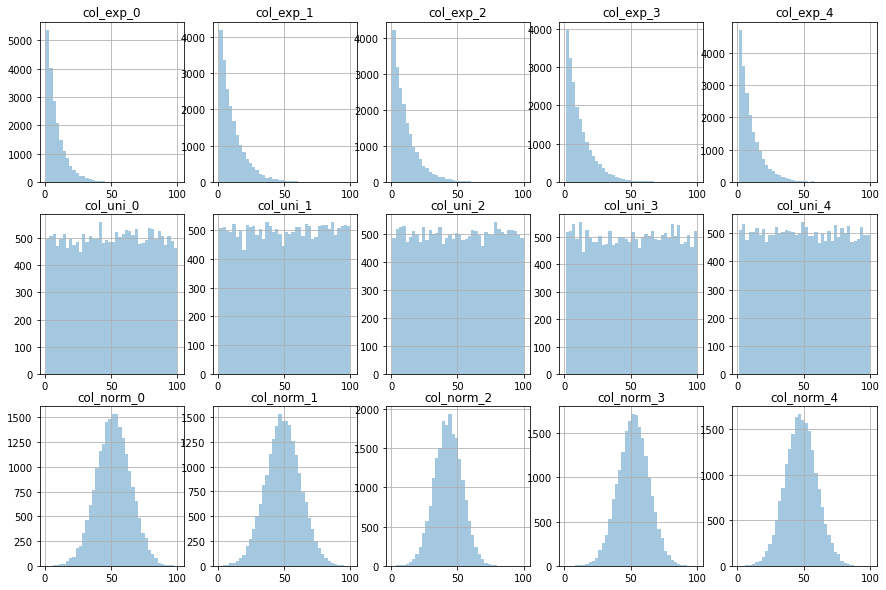

In [7]:
fig, ax = plt.subplots(3,5, figsize=(15,10))

for ix,col in enumerate([col for col in features]):
    ix_horiz = ix%5
    ix_vert = int(ix/5)                  
    data[col].hist(bins=40,alpha=0.4, ax = ax[ix_vert][ix_horiz])
    ax[ix_vert][ix_horiz].set_title(col)

In [8]:
data.columns

Index(['time_col', 'col_exp_0', 'col_exp_1', 'col_exp_2', 'col_exp_3',
       'col_exp_4', 'col_uni_0', 'col_uni_1', 'col_uni_2', 'col_uni_3',
       'col_uni_4', 'col_norm_0', 'col_norm_1', 'col_norm_2', 'col_norm_3',
       'col_norm_4'],
      dtype='object')

In [9]:
make_copy = lambda x: x.copy()

cols_to_shift = [
    col for col in data.columns
    if col.endswith("_2") or col.endswith("_3") or col.endswith("_4")
]
print(cols_to_shift)

exp_cols_to_shift = [col for col in cols_to_shift if 'exp' in col]
exp_uni_to_shift = [col for col in cols_to_shift if 'uni' in col]
exp_norm_to_shift = [col for col in cols_to_shift if 'norm' in col]


data = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data.columns, min_max_scaler_range=(1,100))
)

data_shift = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data.columns, min_max_scaler_range=(1,100))
    .pipe(shift_features, cols_to_shift = exp_cols_to_shift, min_max_scaler_range=(1,150))
        .pipe(shift_features, cols_to_shift = exp_uni_to_shift, min_max_scaler_range=(20,120))
        .pipe(shift_features, cols_to_shift = exp_norm_to_shift, min_max_scaler_range=(-50,150))
)

['col_exp_2', 'col_exp_3', 'col_exp_4', 'col_uni_2', 'col_uni_3', 'col_uni_4', 'col_norm_2', 'col_norm_3', 'col_norm_4']


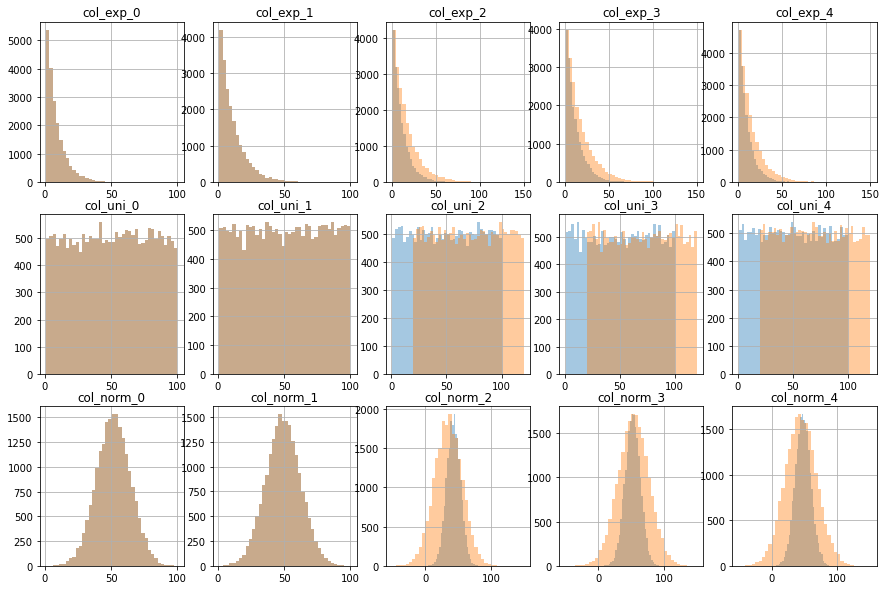

In [10]:
fig, ax = plt.subplots(3,5, figsize=(15,10))

for ix,col in enumerate([col for col in data.columns if "time" not in col]):
    ix_horiz = ix%5
    ix_vert = int(ix/5)                  
    data[col].hist(bins=40,alpha=0.4, ax = ax[ix_vert][ix_horiz])
    data_shift[col].hist(bins=40,alpha=0.4, ax = ax[ix_vert][ix_horiz])
    ax[ix_vert][ix_horiz].set_title(col)

# Time to add the targets

As we are in a simulation setting, let's make the 

`targen` (**Tar**get **Gen**eration) is a package available on pip<br>, and it helps to define a simulated target based on a relationship between features decided by the Data Scientist.<br>
Very handy to test some methodologies in a "controlled" environment <br>
`pip install targen`

In [11]:
from targen.data import target

In [12]:
interaction_terms_1 = "".join([
    "2.5*col_exp_2*col_exp_3",
    "-0.2*col_uni_2*col_uni_3",
    "+0.7*col_norm_2*col_norm_3",
    
    "+0.8*col_norm_2*col_uni_3", #
    "-1.3*col_uni_2/col_exp_3", # the shift shoul reduce here the effect  
])


interaction_terms_2 = "".join([
    "3.5*col_exp_1*col_exp_3",
    "-0.5*col_uni_1*col_uni_4",
    "+0.2*col_norm_2*(col_norm_1-col_norm_0)",
    
    "+2.8*col_norm_1*(col_uni_3+col_norm_0)", #
    "-1.6*col_uni_2/(col_exp_3+0.3*col_norm_0)",
    # the shift shoul reduce here the effect  
])



In [13]:
expressions_1 = {
    'linear': '-0.5*col_exp_0 + 2*col_uni_0 -3.2*col_norm_0',
    'non_linear': '0.7*col_exp_2**1.5 - 0.2*sin(col_norm_2)- 0.9*log(col_uni_2)',
    'interaction': interaction_terms_1,
    'uniform_noise': {
        'weight':7.7
    },
    'gaussian_noise': {
        'weight':12.4,
        'mu_gaus': -1.5
    }
}

expressions_2 = {
    'linear': '-0.5*col_exp_1 + 1.5*col_uni_0 +3.2*col_norm_0',
    'non_linear': '0.7*col_exp_2**1.5 - 0.2*sin(col_norm_1)- 0.9*log(col_uni_2)',
    'interaction': interaction_terms_2,
    'uniform_noise': {
        'weight':9.8
    },
    'gaussian_noise': {
        'weight':15.4,
        'mu_gaus': -1.5
    }
}

In [14]:
data_y_1 = target.get_target_and_contributions(data, expressions=expressions_1, imbalance = 0.4, 
                                             drop_features=False)
data_y_2 = target.get_target_and_contributions(data, expressions=expressions_2, imbalance = 0.3, 
                                             drop_features=False)


In [15]:
data_y_1.columns

Index(['time_col', 'col_exp_0', 'col_exp_1', 'col_exp_2', 'col_exp_3',
       'col_exp_4', 'col_uni_0', 'col_uni_1', 'col_uni_2', 'col_uni_3',
       'col_uni_4', 'col_norm_0', 'col_norm_1', 'col_norm_2', 'col_norm_3',
       'col_norm_4', 'score_linear', 'score_non_linear', 'score_interaction',
       'score_uniform_noise', 'score_gaussian_noise', 'score_total', 'y'],
      dtype='object')

In [16]:
from sklearn.metrics import roc_auc_score

print(f"Linear component: {roc_auc_score(data_y_1['y'],data_y_1['score_linear'])}")
print(f"Non Linear component: {roc_auc_score(data_y_1['y'],data_y_1['score_non_linear'])}")
print(f"Interaction component: {roc_auc_score(data_y_1['y'],data_y_1['score_interaction'])}")
print(f"Total component: {roc_auc_score(data_y_1['y'],data_y_1['score_linear']+data_y_1['score_non_linear']+data_y_1['score_interaction'])}")
print(f"Total component, other target: {roc_auc_score(data_y_2['y'],data_y_1['score_linear']+data_y_1['score_non_linear']+data_y_1['score_interaction'])}")
# print(f"Total component, other target: {roc_auc_score(data_y_1['y'],data_y_2['score_linear']+data_y_2['score_non_linear']+data_y_2['score_interaction'])}")

Linear component: 0.5141052187499999
Non Linear component: 0.6651145833333334
Interaction component: 0.7941510833333332
Total component: 0.7955589583333333
Total component, other target: 0.5750927380952381


In [17]:
features = [col for col in data.columns if col.startswith("col")]

# Build a lighgbm

In [18]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(data_y_1[features],data_y_1['y'], test_size=0.33, random_state=42)

In [19]:
y_train_2 = data_y_2.loc[X_train.index,'y']
y_test_2= data_y_2.loc[X_test.index,'y']

In [20]:
%config Completer.use_jedi = False

In [21]:
import xgboost as xgb

In [22]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

# Train lgb

In [24]:
lgb.LGBMClassifier?

Init signature:
lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None,
    n_jobs=-1,
    silent=True,
    importance_type='split',
    **kwargs,
)
Docstring:      LightGBM classifier.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : string, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart', Dropouts meet Multiple Additive Regression Trees.
    'goss', Gradient-based One-Side Sampling.
    'rf', Random Forest.
num_leaves : int, optional (default=31)
    Maximum tree leaves for base learners.
max_depth : int, optional (default=-1)
    Maximum tree depth f

In [ ]:
%%time

min_frac =int(0.05*X_train.shape[0])
print(min_frac)

lgb_model = lgb.LGBMClassifier(
    num_leaves=4,
    n_estimators=10,
    min_child_samples=min_frac
)

eval_set = [(X_train,y_train_1),(X_test, y_test_1)]

lgb_model.fit(
    X_train,
    y_train_1,
    eval_metric=["auc","logloss"], 
    eval_names = ['validation_0','validation_1'],
    eval_set=eval_set, 
    verbose=30, # after how many training sets you want the printout on the console
    early_stopping_rounds=39
)

fig, ax = plt.subplots(1,2,figsize=(18,8))
ax[0].plot(lgb_model.evals_result_['validation_0']['binary_logloss'], label = "training target")
ax[0].plot(lgb_model.evals_result_['validation_1']['binary_logloss'], label = "test target")
# except:
#     ax[0].plot(model.evals_result_['validation_0']['logloss'], label = "training target")
#     ax[0].plot(model.evals_result_['validation_1']['logloss'], label = "test target")

ax[1].plot(lgb_model.evals_result_['validation_0']['auc'])
ax[1].plot(lgb_model.evals_result_['validation_1']['auc'])
ax[0].legend()



In [ ]:
%%time

min_frac =int(0.05*X_train.shape[0])
print(min_frac)

# model = lgb.LGBMClassifier(
#     num_leaves=4,
#     n_estimators=10,
#     min_child_samples=min_frac
# )

xgb_model = xgb.XGBClassifier(
    max_depth = 2,
    reg_lambda = 0,
    num_leaves=4,
    n_estimators=10,
    min_child_samples=min_frac
)

eval_set = [(X_train,y_train_1),(X_test, y_test_1)]

xgb_model.fit(
    X_train,
    y_train_1,
    eval_metric=["auc","logloss"], 
#     eval_names = ['validation_0','validation_1'],
    eval_set=eval_set, 
    verbose=30, # after how many training sets you want the printout on the console
    early_stopping_rounds=39
)

fig, ax = plt.subplots(1,2,figsize=(18,8))


ax[0].plot(xgb_model.evals_result_['validation_0']['logloss'], label = "training target")
ax[0].plot(xgb_model.evals_result_['validation_1']['logloss'], label = "test target")

ax[1].plot(xgb_model.evals_result_['validation_0']['auc'])
ax[1].plot(xgb_model.evals_result_['validation_1']['auc'])
ax[0].legend()


In [ ]:
from functools import reduce

def plot_proba_evol(X,y,model, max_n_trees=500):
    arrays = list()
    for ix in range(1,max_n_trees+1):
        try:
            pred_ix = model.predict_proba(X, num_iteration=ix)[:,1]
        except:
            pred_ix = model.predict_proba(X, ntree_limit=ix)[:,1]
        arrays.append(pred_ix)
    return np.transpose(reduce(lambda x,y: np.vstack((x,y)),arrays))        
        
    
def find_pred_trend(X,y,model, max_n_trees = 500):
    
    proba_trees = plot_proba_evol(X,y,model, max_n_trees=max_n_trees)
    
#     return proba_trees
    
    mean_y_0 = proba_trees[y.values==0].mean(axis=0)
    std_y_0 = proba_trees[y.values==0].std(axis=0)

    mean_y_1 = proba_trees[y.values==1].mean(axis=0)
    std_y_1 = proba_trees[y.values==1].std(axis=0)
    
    return mean_y_0, std_y_0, mean_y_1, std_y_1

In [ ]:
mean_y_zero_train_1, std_y_zero_train_1, mean_y_one_train_1, std_y_one_train_1 = find_pred_trend(X_train,y_train_1,model,max_n_trees=50)
mean_y_zero_1, std_y_zero_1, mean_y_one_1, std_y_one_1 = find_pred_trend(X_test,y_test_1,model,max_n_trees=50)

mean_y_zero_train_2, std_y_zero_train_2, mean_y_one_train_2, std_y_one_train_2 = find_pred_trend(X_train,y_train_2,model,max_n_trees=50)
mean_y_zero_2, std_y_zero_2, mean_y_one_2, std_y_one_2 = find_pred_trend(X_test,y_test_2,model,max_n_trees=50)


x = [i for i in range(1, mean_y_zero_train_1.shape[0]+1)]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(x,mean_y_zero_train_1, label = "y=0 train", color='orange', linestyle='--')
# ax.fill_between(x, mean_y_zero_train_1-std_y_zero_train_1, mean_y_zero_train_1+std_y_zero_train_1, color='orange',alpha=0.2)

ax.plot(x,mean_y_one_train_1, label = "y=1 train", color='blue',linestyle='--')
# ax.fill_between(x, mean_y_one_train_1-std_y_one_train_1, mean_y_one_train_1+std_y_zero_train_1, color='blue',alpha=0.2)
ax.plot(x,mean_y_zero_1, label = "y=0", color='orange')
ax.plot(x,mean_y_one_1, label = "y=1", color='blue')

ax.plot(x,mean_y_zero_train_2, label = "y=0 train", color='red', linestyle='--')
ax.plot(x,mean_y_one_train_2, label = "y=1 train", color='green',linestyle='--')
ax.plot(x,mean_y_zero_2, label = "y=0", color='red')
ax.plot(x,mean_y_one_2, label = "y=1", color='green')

ax.legend()

# ax[1].plot(std_y_zero_train_1, label = "y=0 train", color='orange', linestyle='--')
# ax[1].plot(std_y_one_train_1, label = "y=1 train", color='blue',linestyle='--')
# ax[1].plot(std_y_zero_1, label = "y=0", color='orange')
# ax[1].plot(std_y_one_1, label = "y=1", color='blue')

In [ ]:
# train_leaf = model.predict(X_train,pred_leaf=True)

# n_trees = train_leaf.shape[1]
# n_trees

# model.predict_proba(X_train, num_iteration=14)

In [ ]:
train_leaf = lgb_model.predict(X_train,pred_leaf=True)
test_leaf = lgb_model.predict(X_test,pred_leaf=True)

train_leaf = pd.DataFrame(train_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])])
test_leaf = pd.DataFrame(test_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])])


In [ ]:
xgb.XGBClassifier?

In [ ]:
lgb.LGBMClassifier?

In [ ]:
lgb_model.get_params()

# Get leaves outputs

In [ ]:
model.

In [ ]:
model.predict

In [ ]:
type(model)

In [ ]:
from functools import reduce

def logloss(y_pred, y_true):
    """Return the gradient and hessian of the log loss.

    Args:
        y_pred (np.array or pd.Series): predictions for the observations, in the range [0,1]
        y_true (np.array or pd.Series): true label for the observations

    Returns:
        tuple: (np.array, np.array), gradient and hessian for the observations
    """
#     prob = 1.0 / (1.0 + np.exp(-y_pred))

    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    grad = y_true - y_pred
    hess = y_pred * (1.0 - y_pred)
    return grad, hess


sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))

def logloss_from_leaves(y_leaf, y_true):
    
#     prob = 1.0 / (1.0 + np.exp(-y_leaf))
    prob = sigmoid(y_leaf)
    
    return logloss(prob, y_true)


def return_leaf(leaves, grad, hess, tree_index=0, model_params=None):
    

    tree_index = tree_index
    reg_lambda = model_params['reg_lambda']
    lr = model_params['learning_rate']
    leaf_outs = {}
    leaves = leaves[:,tree_index]
    for leave_ix in np.unique(leaves):
        leaf_outs[leave_ix] =lr*g[leaves==leave_ix].sum()/(h[leaves==leave_ix].sum() + reg_lambda)
#     leaf_outs

    new_pred = np.array([leaf_outs[ix] for ix in leaves])
    return new_pred



def recompute_leaves(model, X, y):
    start_pred = np.ones(shape = X.shape[0])
    print(start_pred.shape)
    
    try:
        leaves = model.predict(X,pred_leaf=True)
    except:
        leaves = model.apply(X)
    
    n_trees = leaves.shape[1]
    print(n_trees)
    
    pred = start_pred
#     g,h = logloss_from_leaves(pred, y)

    preds = list()
    preds.append(pred)
    
    pred_array = pred.reshape(-1,1)
    
    for tree_index in range(n_trees):
        
        prev_pred = pred_array.sum(axis=1)
        g,h = logloss_from_leaves(prev_pred, y)
        pred = return_leaf(leaves, g, h, tree_index=tree_index, model_params = model.get_params())
        preds.append(pred)
        
        pred_array = np.hstack([pred_array, pred.reshape(-1,1)])
        print(pred_array.shape)
        
   

    model_leaves = np.transpose(reduce(lambda x,y: np.vstack([x,y]),preds))#[:,1:]
    
    return  leaves, model_leaves, pred_array

In [ ]:
leaf_index, leaf_vals, preds = recompute_leaves(model, X_train, y_train_1)

In [ ]:
np.unique(preds[:,2])

In [ ]:
np.hstack([preds[0].reshape(-1,1),preds[1].reshape(-1,1)]).shape

In [ ]:
leaf_vals[:,:2].sum(axis=1)

In [ ]:
np.unique(leaf_vals[:,1])

In [ ]:
sigmoid(leaf_vals[:,:2].sum(axis=1))

In [ ]:
model.predict_proba(X_train, ntree_limit=0)[:,1]

In [ ]:
model_leaves[:,1]

In [ ]:
np.unique(l[:,0])

In [ ]:
from lightgbm import plot_tree

In [ ]:
model.get_params()['learning_rate']

In [ ]:
xgb.XGBClassifier()

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = 0)

In [ ]:
    

tree_index = 0
reg_lambda = 0
leaf_outs = {}
leaves = l[:,tree_index]
for leave_ix in np.unique(leaves):
    leaf_outs[leave_ix] = 0.3*g[leaves==leave_ix].sum()/(h[leaves==leave_ix].sum() + reg_lambda)
    
leaf_outs

new_pred = np.array([leaf_outs[ix] for ix in leaves])


In [ ]:
new_pred = np.array([leaf_outs[ix] for ix in leaves])

In [ ]:
new_pred

In [ ]:
np.unique(l[:,0])

In [ ]:
help(logloss)

In [ ]:
dir(model)

In [ ]:
from sklearn.utils.validation import check_is_fitted


class TransferBoost():
    
    def __init__(self,fitted_model):

#         check_is_fitted(fitted_model)

        self.model = fitted_model
        self.estimators_ = fitted_model.n_estimators
        
    def fit(self, X, y):
        pass
    
    
    

In [ ]:
TransferBoost(model)

In [ ]:
check_is_fitted(model)

In [ ]:
def loglikelihoodloss(y_hat, y_true):
    prob = 1.0 / (1.0 + np.exp(-y_hat))
    grad = prob - y_true
    hess = prob * (1.0 - prob)
    return grad, hess

def recompute_leaves(model, X, y):
    start_pred = 0.5*np.ones(shape = X.shape[0])
    print(start_pred.shape)
    
    leaf = model.predict(X,pred_leaf=True)
    
    n_trees = leaf.shape[1]
    print(n_trees)
    
    pred = start_pred
    g,h = loglikelihoodloss(y,pred)
    
    return  leaf,g,h

def compute_leaves_outputs(leaf_ixs, prev_leaf, ):
    pass

In [ ]:
leaves,grad,hess= recompute_leaves(model, X_train, y_train)

In [ ]:
leaves[:,0].shape

In [ ]:
grad.values

In [ ]:
train_leaf['tree_0'].values, y_train.values, pred  